# Example 13 Electron and nuclear spin mixed state dynamics with [RadicalPy](https://github.com/Spin-Chemistry-Labs/radicalpy)

In this tutorial, one constructs MPO of radical pair system (two electron spins and a couple of nuclear spins under magnetic field) by using RadicalPy library.

For parallelization number of threads should be set before importing any packages

Import required modules

In [1]:
try:
    import radicalpy
except ModuleNotFoundError:
    # remove uv if you are not using uv
    !uv pip install radicalpy --quiet

!uv pip show radicalpy

Using Python 3.12.2 environment at: /home/hinom/GitHub/PyTDSCF-dev/.venv
Name: radicalpy
Version: 0.8.1
Location: /home/hinom/GitHub/PyTDSCF-dev/.venv/lib/python3.12/site-packages
Requires: dot2tex, graphviz, importlib-resources, matplotlib, numpy, pint, scikit-learn, scipy, seaborn, sympy, tqdm
Required-by:


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import radicalpy as rp
from IPython.display import HTML
from pympo import (
    AssignManager,
    OpSite,
    SumOfProducts,
)
from radicalpy.simulation import State
from scipy.linalg import expm
from sympy import Symbol

from pytdscf import BasInfo, Exciton, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian
from pytdscf.util.anim_density_matrix import get_anim

## Vectorisation of density matrix

Density matrix $\rho \in \mathbb{C}^{d \times d}$ can be "vectorised" as

$$
|\rho\rangle\rangle := \mathrm{vec}(\rho) \in \mathbb{C}^{d^2}
$$

where 
$$
\mathrm{vec}(\rho) = \begin{pmatrix}
\rho_{11} \\
\rho_{21} \\
\vdots \\
\rho_{d1} \\
\rho_{12} \\
\vdots \\
\rho_{dd}
\end{pmatrix}
$$

Thus, one-dimensional index (in the sense of column-major order, density matrix: ket->bra) is defined as
$$
(ji) := (j-1)d + i
$$
and 
$$
[\mathrm{vec}(\rho)]_{(ji)} = \rho_{ij}
$$

If one adopt basis $\{|i\rangle\}$,
$$
|i\rangle\langle j| \to |i\rangle \otimes |j\rangle = |ij\rangle\rangle.
$$

Now, dual operation $A\rho B^\dagger$ can be vectorised as
$$
\mathrm{vec}(A\rho B^\dagger) = (B^\ast \otimes A) \mathrm{vec}(\rho)
$$

**Proof**
> $$[A\rho B^\dagger]_{ij} = \sum_{k,l} A_{ik} \rho_{kl} B^\ast_{jl}$$
> $$\therefore \mathrm{vec}(A\rho B^\dagger)_{(ji)} = \sum_{k,l} (B_{jl}^\ast A_{ik}) \rho_{kl} = \{(B^\ast \otimes A) \mathrm{vec}(\rho) \}_{(ji)} $$



## Vectorisation of the von Neumann equation

von Neumann equation is
$$
i\hbar \frac{d}{dt} \rho = [H, \rho] = H\rho I^\dagger - I\rho H^\dagger \; (\because H=H^\dagger, I = I^\dagger)
$$
Thus, its vectorised form is
$$
i\hbar \frac{d}{dt} |\rho\rangle\rangle = (I \otimes H - H^\ast \otimes I) |\rho\rangle\rangle
$$


## Total Hamiltonian
$$
\hat{H}_{\text{total}} =
\hat{H}_{\text{Z}} + \hat{H}_{\text{H}} + \hat{H}_{\text{J}} + \hat{H}_{\text{D}}    
$$

## Define systems

In [3]:
# You can use following block instead
n_nuc_spins = (
    1  # In total, 3*2=6 nuclear spins + 2 electrons = 2^8 Hilbert space
)
flavin = rp.simulation.Molecule.fromisotopes(
    isotopes=["1H"] * n_nuc_spins, hfcs=[0.4] * n_nuc_spins
)
Z = rp.simulation.Molecule.fromisotopes(
    isotopes=["1H"] * n_nuc_spins, hfcs=[0.5] * n_nuc_spins
)
sim = rp.simulation.HilbertSimulation([flavin, Z])

# Parameters
A = {}  # mT
isotropic = True

# Isotropic
for i in range(len(sim.radicals)):
    for j, nuc in enumerate(sim.molecules[i].nuclei):
        if isotropic:
            A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
        else:
            A[(i, j)] = nuc.hfc.anisotropic
B0 = 0.0  # 2J
B = np.array((0.0, 0.0, 1.0)) * B0  # mT
J = 0.0  # Typically 1.0e+03 scale # mT

D = 0.0  # mT

if isinstance(D, float):
    D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D * sim.radicals[0].gamma_mT
sim

Number of electrons: 2
Number of nuclei: 2
Number of particles: 4
Multiplicities: [2, 2, 2, 2]
Magnetogyric ratios (mT): [-176085963.023, -176085963.023, 267522.18744, 267522.18744]
Nuclei: [1H(267522187.44, 2, 0.4 <anisotropic not available>), 1H(267522187.44, 2, 0.5 <anisotropic not available>)]
Couplings: [0, 1]
HFCs (mT): [0.4 <anisotropic not available>, 0.5 <anisotropic not available>]

Now, one defines matrix product state (MPS) in the following order

(nuclei in `flavin`) $\to$ (electronic states $\{|T_{+}\rangle, |T_{0}\rangle, |S\rangle, |T_{-}\rangle\}$) $\to$ (neclei in `Z`)

## Extract one particle operator

RadicalPy provides variety of spin operators such as 

- $\hat{s}_x, \hat{s}_y, \hat{s}_z$ for radical singlet-triplet basis
- $\hat{I}_x, \hat{I}_y, \hat{I}_z$ for nuclear Zeeman basis

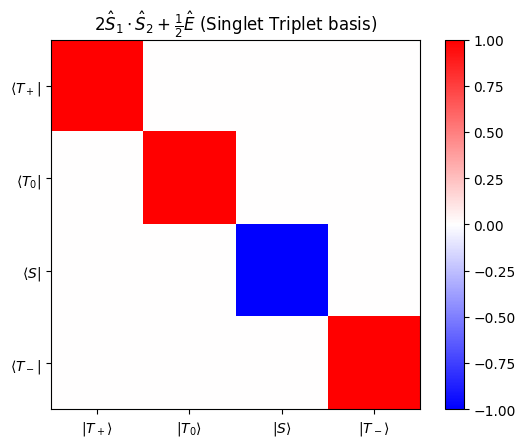

In [4]:
# Clear nuclei temporally
_nuclei_tmp0 = sim.molecules[0].nuclei
_nuclei_tmp1 = sim.molecules[1].nuclei
sim.molecules[0].nuclei = []
sim.molecules[1].nuclei = []

# for Singlet-Triplet basis
sx_1 = sim.spin_operator(0, "x")
sy_1 = sim.spin_operator(0, "y")
sz_1 = sim.spin_operator(0, "z")
sx_2 = sim.spin_operator(1, "x")
sy_2 = sim.spin_operator(1, "y")
sz_2 = sim.spin_operator(1, "z")

# Revert nuclei
sim.molecules[0].nuclei = _nuclei_tmp0
sim.molecules[1].nuclei = _nuclei_tmp1

plt.imshow(
    2 * (sx_1 @ sx_2 + sy_1 @ sy_2 + sz_1 @ sz_2).real
    + 0.5 * np.eye(*sx_1.shape),
    cmap="bwr",
    vmin=-1.0,
    vmax=1.0,
)
plt.title(
    r"$2\hat{S}_1\cdot \hat{S}_2 + \frac{1}{2}\hat{E}$ (Singlet Triplet basis)"
)
plt.colorbar()
plt.xticks(
    [0, 1, 2, 3],
    [r"$|T_+\rangle$", r"$|T_0\rangle$", r"$|S\rangle$", r"$|T_-\rangle$"],
)
plt.yticks(
    [0, 1, 2, 3],
    [
        r"$\langle T_+|$",
        r"$\langle T_0 |$",
        r"$\langle S|$",
        r"$\langle T_- |$",
    ],
)
plt.show()

## Define `OpSite` and coefficients

- RadicalPy uses Hz in energy unit but it is too large to keep numerical stabiltiy
- Thus, one will use GHz in energy unit
- For some reasons, extraction of imaginary unit of pauli y operator leads stable simulation for degenerate system (why??)

In [5]:
SCALE = 1.0e-09
gamma = [p.gamma_mT for p in sim.particles]

g_ele_sym = [
    Symbol(r"\gamma_e^{(" + f"{i + 1}" + ")}") for i in range(len(sim.radicals))
]
g_nuc_sym = {}
for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        g_nuc_sym[(i, j)] = Symbol(r"\gamma_n^{" + f"{(i + 1, j + 1)}" + "}")

subs = {}
for i, ge in enumerate(g_ele_sym):
    subs[ge] = sim.radicals[i].gamma_mT
for (i, j), gn in g_nuc_sym.items():
    subs[gn] = sim.molecules[i].nuclei[j].gamma_mT

Define radical spin operators

In [6]:
def get_OE(op):
    return np.kron(op.T, np.eye(op.shape[0], dtype=op.dtype))


def get_EO(op):
    return np.kron(np.eye(op.shape[0], dtype=op.dtype), op)


ele_site = len(sim.molecules[0].nuclei)

SxE_ops = []
SyE_ops = []
SzE_ops = []
ESx_ops = []
ESy_ops = []
ESz_ops = []

S1S2E_op = OpSite(
    r"(\hat{S}_1\cdot\hat{S}_2)^\ast \otimes\mathbb{1}",
    ele_site,
    value=np.kron(
        (sx_1 @ sx_2 + sy_1 @ sy_2 + sz_1 @ sz_2).conjugate(),
        np.eye(sx_1.shape[0]),
    ),
)
ES1S2_op = OpSite(
    r"\mathbb{1}\otimes(\hat{S}_1\cdot\hat{S}_2)",
    ele_site,
    value=np.kron(
        np.eye(sx_1.shape[0]), sx_1 @ sx_2 + sy_1 @ sy_2 + sz_1 @ sz_2
    ),
)
EE_op = OpSite(
    r"\hat{E}\otimes\hat{E}",
    ele_site,
    value=np.kron(np.eye(sx_1.shape[0]), np.eye(sx_1.shape[0])),
)

SxE_ops.append(
    OpSite(
        r"\hat{S}_x^{(1)\ast}\otimes\mathbb{1}", ele_site, value=get_OE(sx_1)
    )
)
ESx_ops.append(
    OpSite(r"\mathbb{1}\otimes\hat{S}_x^{(1)}", ele_site, value=get_EO(sx_1))
)
SyE_ops.append(
    OpSite(
        r"\hat{S}_y^{(1)\ast}\otimes\mathbb{1}", ele_site, value=get_OE(sy_1)
    )
)
ESy_ops.append(
    OpSite(r"\mathbb{1}\otimes\hat{S}_y^{(1)}", ele_site, value=get_EO(sy_1))
)
SzE_ops.append(
    OpSite(
        r"\hat{S}_z^{(1)\ast}\otimes\mathbb{1}", ele_site, value=get_OE(sz_1)
    )
)
ESz_ops.append(
    OpSite(r"\mathbb{1}\otimes\hat{S}_z^{(1)}", ele_site, value=get_EO(sz_1))
)

SxE_ops.append(
    OpSite(
        r"\hat{S}_x^{(2)\ast}\otimes\mathbb{1}", ele_site, value=get_OE(sx_2)
    )
)
ESx_ops.append(
    OpSite(r"\mathbb{1}\otimes\hat{S}_x^{(2)}", ele_site, value=get_EO(sx_2))
)
SyE_ops.append(
    OpSite(
        r"\hat{S}_y^{(2)\ast}\otimes\mathbb{1}", ele_site, value=get_OE(sy_2)
    )
)
ESy_ops.append(
    OpSite(r"\mathbb{1}\otimes\hat{S}_y^{(2)}", ele_site, value=get_EO(sy_2))
)
SzE_ops.append(
    OpSite(
        r"\hat{S}_z^{(2)\ast}\otimes\mathbb{1}", ele_site, value=get_OE(sz_2)
    )
)
ESz_ops.append(
    OpSite(r"\mathbb{1}\otimes\hat{S}_z^{(2)}", ele_site, value=get_EO(sz_2))
)

SrE_ops = [SxE_ops, SyE_ops, SzE_ops]
ESr_ops = [ESx_ops, ESy_ops, ESz_ops]

Define nuclear spin operators

In [7]:
IxE_ops = {}
IyE_ops = {}
IzE_ops = {}
EIx_ops = {}
EIy_ops = {}
EIz_ops = {}

for j, nuc in enumerate(sim.molecules[0].nuclei):
    val = nuc.pauli["x"]
    IxE_ops[(0, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(1, j + 1)}" + r"\ast}\otimes\mathbb{1}",
        j,
        value=get_OE(val),
    )
    EIx_ops[(0, j)] = OpSite(
        r"\mathbb{1}\otimes\hat{I}_x^{" + f"{(1, j + 1)}" + "}",
        j,
        value=get_EO(val),
    )
    val = nuc.pauli["y"]
    IyE_ops[(0, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(1, j + 1)}" + r"\ast}\otimes\mathbb{1}",
        j,
        value=get_OE(val),
    )
    EIy_ops[(0, j)] = OpSite(
        r"\mathbb{1}\otimes\hat{I}_y^{" + f"{(1, j + 1)}" + "}",
        j,
        value=get_EO(val),
    )
    val = nuc.pauli["z"]
    IzE_ops[(0, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(1, j + 1)}" + r"\ast}\otimes\mathbb{1}",
        j,
        value=get_OE(val),
    )
    EIz_ops[(0, j)] = OpSite(
        r"\mathbb{1}\otimes\hat{I}_z^{" + f"{(1, j + 1)}" + "}",
        j,
        value=get_EO(val),
    )

for j, nuc in enumerate(sim.molecules[1].nuclei):
    val = nuc.pauli["x"]
    IxE_ops[(1, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(2, j + 1)}" + r"\ast}\otimes\mathbb{1}",
        ele_site + 1 + j,
        value=get_OE(val),
    )
    EIx_ops[(1, j)] = OpSite(
        r"\mathbb{1}\otimes\hat{I}_x^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=get_EO(val),
    )
    val = nuc.pauli["y"]
    IyE_ops[(1, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(2, j + 1)}" + r"\ast}\otimes\mathbb{1}",
        ele_site + 1 + j,
        value=get_OE(val),
    )
    EIy_ops[(1, j)] = OpSite(
        r"\mathbb{1}\otimes\hat{I}_y^{" + f"{(1, j + 1)}" + "}",
        j,
        value=get_EO(val),
    )
    val = nuc.pauli["z"]
    IzE_ops[(1, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(2, j + 1)}" + r"\ast}\otimes\mathbb{1}",
        ele_site + 1 + j,
        value=get_OE(val),
    )
    EIz_ops[(1, j)] = OpSite(
        r"\mathbb{1}\otimes\hat{I}_z^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=get_EO(val),
    )

IrE_ops = [IxE_ops, IyE_ops, IzE_ops]
EIr_ops = [EIx_ops, EIy_ops, EIz_ops]

## Hyperfine coupling Hamiltonian
$$
\hat{H}_{\text{H}} = \sum_i \sum_j \hat{S}_i\cdot A_{ij}\cdot \hat{I}_{ij}
= \sum_i \sum_j \sum_{r\in\{x, y, z\}} A_{ij}\hat{S}_{r}^{(i)}\hat{I}_{r}^{(ij)}
$$

In [8]:
hyperfine = SumOfProducts()

xyz = "xyz"

for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        for k, (SrE_op, ESr_op) in enumerate(
            zip(SrE_ops, ESr_ops, strict=True)
        ):
            for l, (IrE_op, EIr_op) in enumerate(
                zip(IrE_ops, EIr_ops, strict=True)
            ):
                if A[(i, j)][k, l] == 0.0:
                    continue
                Asym = Symbol(
                    "A^{"
                    + f"{(i + 1, j + 1)}"
                    + "}_{"
                    + f"{xyz[k]}"
                    + f"{xyz[l]}"
                    + "}"
                )
                subs[Asym] = A[(i, j)][k, l].item() * SCALE
                hyperfine -= Asym * g_ele_sym[i] * SrE_op[i] * IrE_op[(i, j)]
                hyperfine += Asym * g_ele_sym[i] * ESr_op[i] * EIr_op[(i, j)]

In [9]:
hyperfine = hyperfine.simplify()
hyperfine.symbol

-A^{(1, 1)}_{xx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)\ast}\otimes\mathbb{1}*\hat{S}_x^{(1)\ast}\otimes\mathbb{1} + A^{(1, 1)}_{xx}*\gamma_e^{(1)}*\mathbb{1}\otimes\hat{I}_x^{(1, 1)}*\mathbb{1}\otimes\hat{S}_x^{(1)} - A^{(1, 1)}_{yy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)\ast}\otimes\mathbb{1}*\hat{S}_y^{(1)\ast}\otimes\mathbb{1} + A^{(1, 1)}_{yy}*\gamma_e^{(1)}*\mathbb{1}\otimes\hat{I}_y^{(1, 1)}*\mathbb{1}\otimes\hat{S}_y^{(1)} - A^{(1, 1)}_{zz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)\ast}\otimes\mathbb{1}*\hat{S}_z^{(1)\ast}\otimes\mathbb{1} + A^{(1, 1)}_{zz}*\gamma_e^{(1)}*\mathbb{1}\otimes\hat{I}_z^{(1, 1)}*\mathbb{1}\otimes\hat{S}_z^{(1)} - A^{(2, 1)}_{xx}*\gamma_e^{(2)}*\hat{S}_x^{(2)\ast}\otimes\mathbb{1}*\hat{I}_x^{(2, 1)\ast}\otimes\mathbb{1} + A^{(2, 1)}_{xx}*\gamma_e^{(2)}*\mathbb{1}\otimes\hat{S}_x^{(2)}*\mathbb{1}\otimes\hat{I}_x^{(2, 1)} - A^{(2, 1)}_{yy}*\gamma_e^{(2)}*\hat{S}_y^{(2)\ast}\otimes\mathbb{1}*\hat{I}_y^{(2, 1)\ast}\otimes\mathbb{1} + A^{(2, 1)}_{yy}*\gamma_e^{(2)}*\mathbb{1}

## Zeeman Hamiltonian
$$
\hat{H}_{\text{Z}}
= - \vec{B} \cdot \sum_i \left(\gamma_{\text{e}}\vec{S}^{(i)} + \left(\sum_j\gamma_{\text{n}}^{(ij)}\vec{I}^{(ij)}\right)\right)
$$

In [10]:
zeeman = SumOfProducts()

xyz = "xyz"

for k, (SrE_op, ESr_op, IrE_op, EIr_op) in enumerate(
    zip(SrE_ops, ESr_ops, IrE_ops, EIr_ops, strict=True)
):
    if B[k] == 0.0:
        continue
    r = xyz[k]
    Br = Symbol(f"B_{r}")
    subs[Br] = B[k] * SCALE
    for i in range(len(sim.radicals)):
        zeeman += -Br * g_ele_sym[i] * ESr_op[i]
        zeeman += Br * g_ele_sym[i] * SrE_op[i]
        for j in range(len(sim.molecules[i].nuclei)):
            zeeman += -Br * g_nuc_sym[(i, j)] * EIr_op[(i, j)]
            zeeman += Br * g_nuc_sym[(i, j)] * IrE_op[(i, j)]

zeeman = zeeman.simplify()
zeeman.symbol

0

## Exchange Hamiltonian
$$
\hat{H}_{\text{J}}
= J \gamma_e \left(\vec{S}_1\cdot\vec{S_2}+\frac{1}{2}\hat{E}\right)
$$

In [11]:
exchange = SumOfProducts()
if J != 0.0:
    Jsym = Symbol("J")
    subs[Jsym] = J * SCALE
    exchange += Jsym * g_ele_sym[0] * (2 * ES1S2_op + 0.5 * EE_op)
    exchange -= Jsym * g_ele_sym[1] * (2 * S1S2E_op + 0.5 * EE_op)
    exchange = exchange.simplify()
exchange.symbol

0

## Dipolar Hamiltonian
$$
\hat{H}_{\text{J}}
= \vec{S}_1^\top \cdot D \cdot \vec{S_2}
$$

In [12]:
dipolar = SumOfProducts()
for k in range(3):
    for l in range(3):
        if D[k, l] == 0.0:
            continue
        else:
            Dsym = Symbol("D_{" + f"{xyz[k]}" + f"{xyz[l]}" + "}")
            subs[Dsym] = D[k, l] * SCALE
            dipolar += Dsym * ESr_ops[k][0] * ESr_ops[l][1]
            dipolar -= Dsym * SrE_ops[k][0] * SrE_ops[l][1]
dipolar = dipolar.simplify()
dipolar.symbol

0

Construct matrix product operator (MPO) for MPS propagation

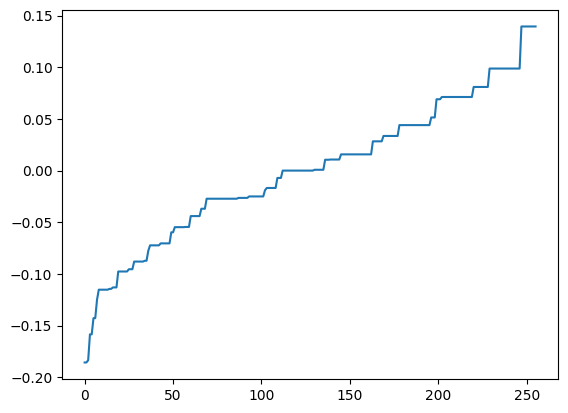

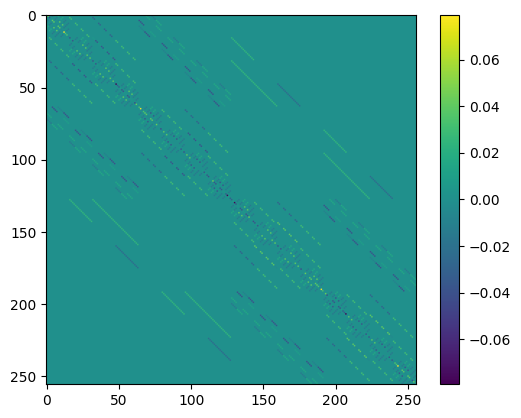

0.0


-A^{(1, 1)}_{xx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)\ast}\otimes\mathbb{1}*\hat{S}_x^{(1)\ast}\otimes\mathbb{1} + A^{(1, 1)}_{xx}*\gamma_e^{(1)}*\mathbb{1}\otimes\hat{I}_x^{(1, 1)}*\mathbb{1}\otimes\hat{S}_x^{(1)} - A^{(1, 1)}_{yy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)\ast}\otimes\mathbb{1}*\hat{S}_y^{(1)\ast}\otimes\mathbb{1} + A^{(1, 1)}_{yy}*\gamma_e^{(1)}*\mathbb{1}\otimes\hat{I}_y^{(1, 1)}*\mathbb{1}\otimes\hat{S}_y^{(1)} - A^{(1, 1)}_{zz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)\ast}\otimes\mathbb{1}*\hat{S}_z^{(1)\ast}\otimes\mathbb{1} + A^{(1, 1)}_{zz}*\gamma_e^{(1)}*\mathbb{1}\otimes\hat{I}_z^{(1, 1)}*\mathbb{1}\otimes\hat{S}_z^{(1)} - A^{(2, 1)}_{xx}*\gamma_e^{(2)}*\hat{S}_x^{(2)\ast}\otimes\mathbb{1}*\hat{I}_x^{(2, 1)\ast}\otimes\mathbb{1} + A^{(2, 1)}_{xx}*\gamma_e^{(2)}*\mathbb{1}\otimes\hat{S}_x^{(2)}*\mathbb{1}\otimes\hat{I}_x^{(2, 1)} - A^{(2, 1)}_{yy}*\gamma_e^{(2)}*\hat{S}_y^{(2)\ast}\otimes\mathbb{1}*\hat{I}_y^{(2, 1)\ast}\otimes\mathbb{1} + A^{(2, 1)}_{yy}*\gamma_e^{(2)}*\mathbb{1}

In [13]:
hamiltonian = hyperfine + zeeman + exchange + dipolar
hamiltonian = hamiltonian.simplify()
am = AssignManager(hamiltonian)
_ = am.assign()
# display(*am.Wsym)
mpo = am.numerical_mpo(subs=subs)

from pympo.utils import full_matrix

full_ham = full_matrix(mpo)
val, vec = np.linalg.eigh(full_ham)
plt.plot(val.real)
plt.show()


plt.imshow(full_ham.real)
plt.colorbar()
plt.show()
np.testing.assert_allclose(
    full_ham, full_ham.T.conj(), atol=1e-14
)  # check if mpo is Hermitian

print(np.max(np.abs(full_ham.imag)))
hamiltonian.symbol

## Mixed state (ensemble) simulation

In [14]:
backend = "numpy"
m = 32  # Bond dimension
Δt = 5.0e-10 / SCALE * units.au_in_fs  # dt = 0.5 ns

In [15]:
basis = []
for nuc in sim.molecules[0].nuclei:
    # basis.append(Exciton(nstate=nuc.multiplicity))
    basis.append(Exciton(nstate=nuc.multiplicity**2))
# basis.append(Exciton(nstate=4))
basis.append(Exciton(nstate=4**2))
for nuc in sim.molecules[1].nuclei:
    # basis.append(Exciton(nstate=nuc.multiplicity))
    basis.append(Exciton(nstate=nuc.multiplicity**2))
basinfo = BasInfo([basis], spf_info=None)

nsite = len(basis)
for i in range(nsite):
    print(basis[i].nstate)

4
16
4


In [16]:
op_dict = {
    tuple([(isite, isite) for isite in range(nsite)]): TensorOperator(mpo=mpo)
}
H = TensorHamiltonian(
    nsite, potential=[[op_dict]], kinetic=None, backend=backend
)

17:36:20 | INFO | Start tensor decomposition: type = QRD


In [17]:
def singlet_state():
    hp = []
    for isite in range(nsite):
        if isite == ele_site:
            hp.append(np.diag([0.0, 0.0, 1.0, 0.0]).reshape(-1).tolist())
            print(hp[-1])
        else:
            from math import isqrt

            hp.append(
                (
                    np.eye(isqrt(basis[isite].nstate))
                    / isqrt(basis[isite].nstate)
                )
                .reshape(-1)
                .tolist()
            )
            print(hp[-1])
    return hp


def to_full_vector(mps: list[np.ndarray]) -> np.ndarray:
    vec = mps[0][0, :, :]
    for core in mps[1:]:
        vec = np.einsum("...i,ijk->...jk", vec, core)
    return vec.reshape(-1)


def process(i, H):
    operators = {"hamiltonian": H}
    model = Model(basinfo=basinfo, operators=operators)
    model.m_aux_max = m
    hp = singlet_state()
    model.init_HartreeProduct = [hp]

    jobname = f"radicalpair_{i}"
    simulator = Simulator(
        jobname=jobname,
        model=model,
        backend=backend,
        verbose=0,
        nonHermitian=True,
    )
    # Initiate the propagation setting with maxstep=0
    ener, wf = simulator.propagate(
        reduced_density=(
            [(ele_site, ele_site)],
            2,
        ),
        maxstep=0,
        stepsize=Δt,
        autocorr=False,
        energy=False,
        norm=False,
        populations=False,
    )

    full_vec = to_full_vector(
        [core.data for core in wf.ci_coef.superblock_states[0]]
    ).reshape(-1, 1)
    full_propagator = expm(full_ham * 5.0e-10 / SCALE / 1.0j)
    full_vecs = [full_vec]
    nstep = 100
    for i in range(nstep):
        full_vecs.append(full_propagator @ full_vecs[-1])

    # Manually propagate wavefunction
    dt = Δt / units.au_in_fs
    from math import isqrt

    def get_partial_trace(mps: list[np.ndarray], sys_site: int) -> np.ndarray:
        nsite = len(mps)
        left_env = np.array([1.0 + 0.0j])
        for isite in range(sys_site):
            data = mps[isite]
            data = data.reshape(
                data.shape[0],
                isqrt(data.shape[1]),
                isqrt(data.shape[1]),
                data.shape[2],
                order="C",
            )
            left_env = np.einsum("i,ijjl->l", left_env, data)

        right_env = np.array([1.0 + 0.0j])
        for isite in range(nsite - 1, sys_site, -1):
            data = mps[isite]
            data = data.reshape(
                data.shape[0],
                isqrt(data.shape[1]),
                isqrt(data.shape[1]),
                data.shape[2],
                order="C",
            )
            right_env = np.einsum("ijjl,l->i", data, right_env)
        dm = np.einsum(
            "i,ijkl,l->jk",
            left_env,
            mps[sys_site].reshape(
                mps[sys_site].shape[0],
                isqrt(mps[sys_site].shape[1]),
                isqrt(mps[sys_site].shape[1]),
                mps[sys_site].shape[2],
                order="C",
            ),
            right_env,
        )
        return dm

    time_data = np.arange(nstep + 1) * Δt
    density_data = []
    density_data.append(
        get_partial_trace(
            [core.data for core in wf.ci_coef.superblock_states[0]], ele_site
        )
    )
    # from pympo import utils
    # full = utils.full_matrix([core.data.reshape(core.data.shape[0], isqrt(core.data.shape[1]), isqrt(core.data.shape[1]), core.data.shape[2], order="C") for core in wf.ci_coef.superblock_states[0]])
    # plt.imshow(full.real)
    # plt.colorbar()
    # plt.show()

    # full = full.reshape(2, 4, 2, 2, 4, 2)
    # dm = np.einsum("aibajb->ij", full)
    # plt.imshow(dm.real)
    # plt.show()

    for i in range(nstep):
        wf.propagate_SM(simulator.model.hamiltonian, dt, istep=i)
        density_data.append(
            get_partial_trace(
                [core.data for core in wf.ci_coef.superblock_states[0]],
                ele_site,
            )
        )
    density_data = np.array(density_data, dtype=np.complex128)

    return density_data, time_data, np.array(full_vecs)

Since nuclear spins are mixed state, one needs to consider ensemble of nuclear spin initial states. 
The calculation is performed in parallel for each trajectory.
When the number of nuclear spins large, switch to quasi Monte Carlo approach. 

17:36:20 | WARNING | Non-Hermitian calculation is experimental.
17:36:20 | INFO | Wave function is saved in wf_radicalpair_0.pkl
17:36:20 | INFO | Start initial step    0.000 [fs]
17:36:20 | INFO | End simulation and save wavefunction
17:36:20 | INFO | Wave function is saved in wf_radicalpair_0.pkl


[0.5, 0.0, 0.0, 0.5]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.5, 0.0, 0.0, 0.5]


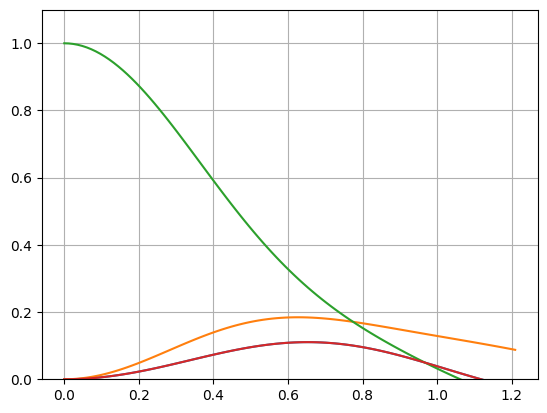

In [18]:
density_data, time_data, fullvecs = process(0, H)
rdm = np.einsum("taaijbb->tij", fullvecs.reshape(-1, 2, 2, 4, 4, 2, 2))
plt.plot(time_data[:], rdm[:, 0, 0].real)
plt.plot(time_data[:], rdm[:, 1, 1].real)
plt.plot(time_data[:], rdm[:, 2, 2].real)
plt.plot(time_data[:], rdm[:, 3, 3].real)
plt.ylim(0, 1.1)
plt.grid()
plt.show()

In [19]:
time_data_μs = time_data * SCALE * 1e06 / units.au_in_fs

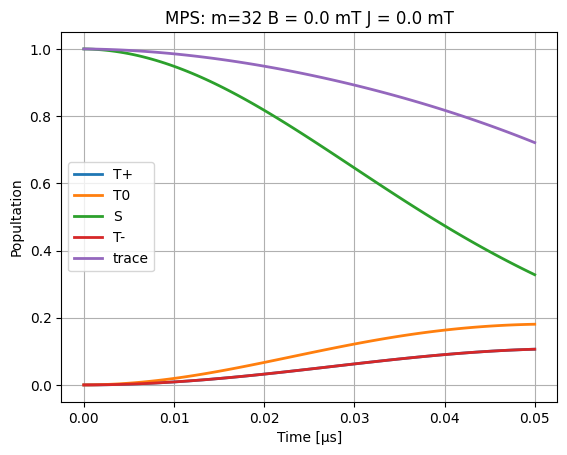

In [20]:
plt.plot(time_data_μs, density_data[:, 0, 0].real, linewidth=2, label="T+")
plt.plot(time_data_μs, density_data[:, 1, 1].real, linewidth=2, label="T0")
plt.plot(time_data_μs, density_data[:, 2, 2].real, linewidth=2, label="S")
plt.plot(time_data_μs, density_data[:, 3, 3].real, linewidth=2, label="T-")
plt.plot(
    time_data_μs,
    density_data[:, 0, 0].real
    + density_data[:, 1, 1].real
    + density_data[:, 2, 2].real
    + density_data[:, 3, 3].real,
    linewidth=2,
    label="trace",
)
plt.title(f"MPS: {m=} B = {B0} mT J = {J} mT")
plt.legend()
plt.xlabel("Time [μs]")
plt.ylabel("Popultation")
plt.grid()
# plt.ylim([0, 1])
plt.savefig("population.png")
plt.show()

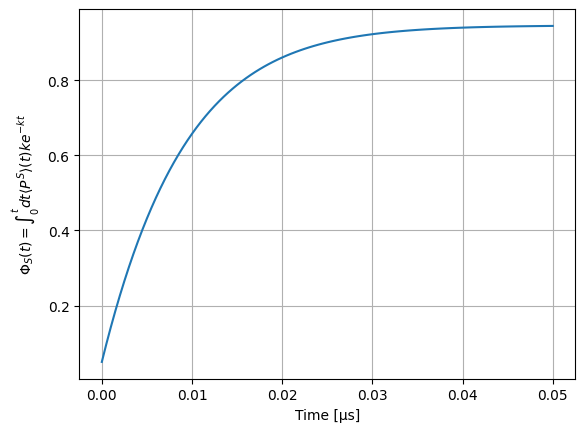

In [21]:
dt = time_data_μs[1] - time_data[0]
k_s = 1e2  # 1/micro sec, typically 1.0~0.1
phi_s = np.cumsum(
    density_data[:, 2, 2].real * dt * k_s * np.exp(-k_s * time_data_μs)
)

plt.plot(time_data_μs, phi_s)
plt.xlabel("Time [μs]")
plt.ylabel(r"$\Phi_S(t)=\int_0^t dt \langle P^S \rangle(t) ke^{-kt} $")
plt.grid()
plt.savefig("population.png")
plt.show()

Saving animation to rdm-radical.gif...
Animation saved successfully!


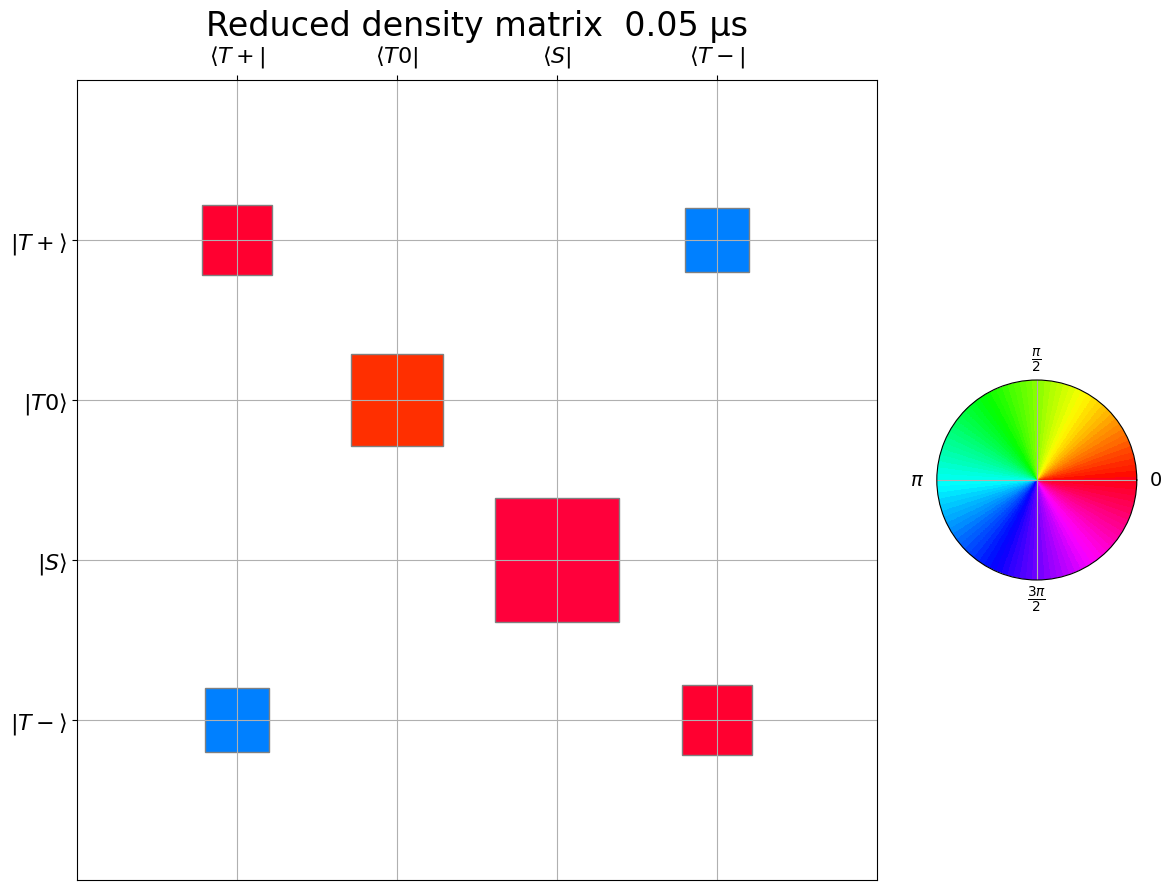

In [22]:
# Note: spin coherent state sampling has slower convergence for off-diagnal term than projection state sampling
fig, anim = get_anim(
    density_data[::1, :, :],
    time_data_μs[::1],
    title="Reduced density matrix",
    time_unit="μs",
    save_gif=True,
    dpi=30,
    gif_filename="rdm-radical.gif",
    row_names=[
        r"$|T+\rangle$",
        r"$|T0\rangle$",
        r"$|S\rangle$",
        r"$|T-\rangle$",
    ],
    col_names=[
        r"$\langle T+|$",
        r"$\langle T0|$",
        r"$\langle S|$",
        r"$\langle T-|$",
    ],
)
plt.show()
HTML(anim.to_jshtml())

## Compare with RadicalPy simulation

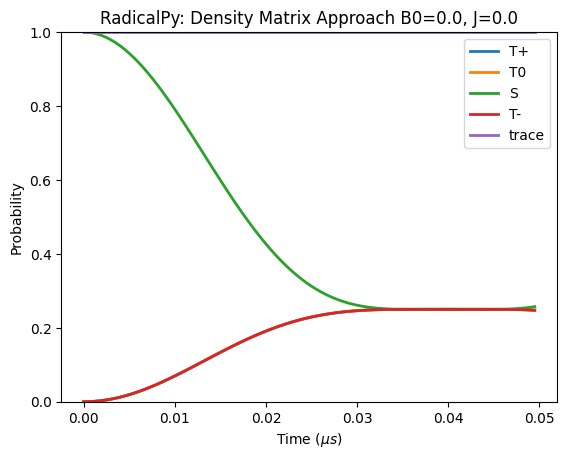

In [23]:
if len(basis) < 8:
    assert isinstance(D, np.ndarray)
    H = sim.total_hamiltonian(B0=B0, D=D, J=J)
    time = np.arange(0, 5e-8, 5e-10)
    rhos = sim.time_evolution(State.SINGLET, time, H)
    time_evol_s = sim.product_probability(State.SINGLET, rhos)
    time_evol_tp = sim.product_probability(State.TRIPLET_PLUS, rhos)
    time_evol_tz = sim.product_probability(State.TRIPLET_ZERO, rhos)
    time_evol_tm = sim.product_probability(State.TRIPLET_MINUS, rhos)
    x = time * 1e6

    plt.plot(x, time_evol_tp, linewidth=2, label="T+")
    plt.plot(x, time_evol_tz, linewidth=2, label="T0")
    plt.plot(x, time_evol_s, linewidth=2, label="S")
    plt.plot(x, time_evol_tm, linewidth=2, label="T-")
    plt.plot(
        x,
        time_evol_tp + time_evol_tz + time_evol_s + time_evol_tm,
        linewidth=2,
        label="trace",
    )
    plt.legend()
    plt.title(f"RadicalPy: Density Matrix Approach {B0=}, {J=}")
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.show()

In [24]:
# Clean files
!rm -rf radicalpair_*_prop
!rm -f wf_radicalpair_*.pkl

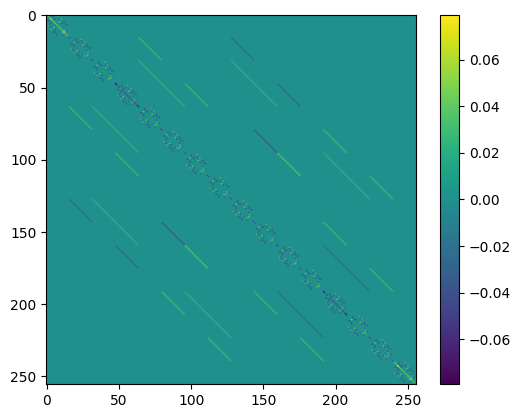

np.float64(0.07923868336035002)

In [25]:
total_ham = sim.total_hamiltonian(0, 0, 0) * SCALE
eye = np.eye(total_ham.shape[0])
total_ham_vec = -np.kron(total_ham.T, eye) + np.kron(eye, total_ham)
plt.imshow(total_ham_vec.real)
plt.colorbar()
plt.show()
np.max(np.abs(total_ham_vec.real))

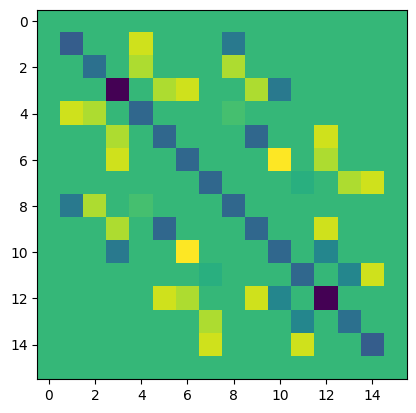

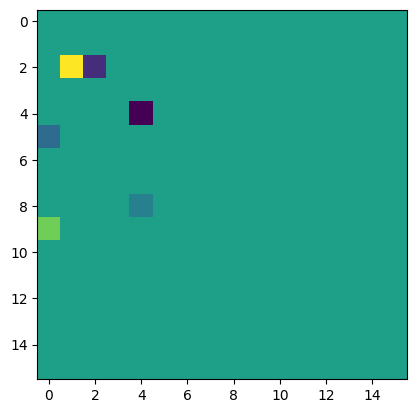

In [26]:
total_ham_vec_reshaped = total_ham_vec.reshape(16, 4, 4, 16, 4, 4)
plt.imshow(total_ham_vec_reshaped[:, 0, 0, :, 0, 0].real)
plt.show()

full_ham_reshaped = full_ham.reshape(4, 4, 16, 16, 4, 4)
plt.imshow(full_ham_reshaped[0, 0, :, :, 0, 0].real)
plt.show()